# Etiquetado de los registros

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

In [2]:
pd.options.display.max_columns = None
pd.options.display.max_rows = 80

El objetivo de este notebook es asignar a cada registro una etiqueta binaria de acuerdo al comportamiento de cada valor en cada periodo temporal con respecto a un índice de referencia. Este índice lo vamos a construir como una media de las variaciones de precios de un grupo de valores representativos.

De este modo, cuando un valor se comporte mejor que el índice (ya sea porque, porcentualmente, su precio sube más, o porque baja menos) le asignaremos la etiqueta 'mejor'. En caso contrario la etiqueta será 'peor'.

Para nuestro análisis disponemos del campo 'Adj. Close', que se trata del precio de cierre descontando los efectos de acciones corporativas como pago de dividendos, splits, etc., ideal para un análisis a largo plazo como el nuestro.

## Obtención de un índice

Intentamos identificar un grupo homogéneo de valores presente en un periodo de tiempo razonable, lo usaremos para calcular el índice de referencia y como población para aplicar nuestro modelo.

Los precios los normalizaremos en base 100 con respecto al precio del primer trimestre.

El índice de referencia, será la media de estos precios en base 100.

Partimos de la tablas generada mergedbalres y los datos de precios en la tabla 'prices'

### 1) Analizamos los registros de la tabla 'mergedbalres' para identificar el mejor grupo homogéneo de estudio

In [3]:
df_valores = pd.read_csv('../tablas/mergedbalres.csv', index_col='Ref')
df_valores['Publish Date']=pd.to_datetime(df_valores['Publish Date'], format="%Y-%m-%d")

companies = pd.read_csv('../tablas/filteredcompanies.csv', dtype='str')

In [4]:
companies

,Ticker,SimFinId,Company Name,IndustryId,Sector,Industry
0,GOOG,18,Alphabet,101002,Technology,Online Media
1,ATVI,243,Activision Blizzard,101003,Technology,Application Software
2,ADBE,14099,Adobe Systems,101003,Technology,Application Software
3,MMM,22219,3M CO,100001,Industrials,Industrial Products
4,TWTR,30388,"TWITTER, INC.",101002,Technology,Online Media
...,...,...,...,...,...,...
1100,ATNX,785769,"Athenex, Inc.",106002,Healthcare,Biotechnology
1101,TPIC,180206,"TPI COMPOSITES, INC",100001,Industrials,Industrial Products
1102,GRC,122864,GORMAN RUPP CO,100001,Industrials,Industrial Products
1103,ALGN,445691,Align Technology Inc,106004,Healthcare,Medical Devices


In [5]:
# Creamos un campo 'Periodo' formado por el año y el trimestre correspondiente a cada registro
df_valores = df_valores.astype({'Fiscal Year':str})
df_valores['Periodo'] = df_valores['Fiscal Year'] + df_valores['Fiscal Period']

In [6]:
df_valores

,Ticker,SimFinId,Currency,Fiscal Year,Fiscal Period,Report Date,Publish Date,Restated Date,Shares (Basic),Shares (Diluted),"Cash, Cash Equivalents & Short Term Investments",Accounts & Notes Receivable,Inventories,Total Current Assets,"Property, Plant & Equipment, Net",Long Term Investments & Receivables,Other Long Term Assets,Total Noncurrent Assets,Total Assets,Payables & Accruals,Short Term Debt,Total Current Liabilities,Long Term Debt,Total Noncurrent Liabilities,Total Liabilities,Share Capital & Additional Paid-In Capital,Treasury Stock,Retained Earnings,Total Equity,Total Liabilities & Equity,Sector,Revenue,Cost of Revenue,Gross Profit,Operating Expenses,"Selling, General & Administrative",Research & Development,Depreciation & Amortization,Operating Income (Loss),Non-Operating Income (Loss),"Interest Expense, Net","Pretax Income (Loss), Adj.",Abnormal Gains (Losses),Pretax Income (Loss),"Income Tax (Expense) Benefit, Net",Income (Loss) from Continuing Operations,Net Extraordinary Gains (Losses),Net Income,Net Income (Common),Periodo
Ref,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AE2011Q2,AE,191518,USD,2011,Q2,2011-03-31,2011-08-12,2011-08-12,4217596.0,4217596.0,36687000.0,212748000.0,20393000.0,286520000.0,69562000.0,NaN,3306000.0,72868000.0,359388000,244369000.0,NaN,251296000.0,NaN,8765000.0,260061000,12115000.0,NaN,87212000.0,99327000.0,359388000,Energy,777538000.0,-16147000.0,761391000.0,-755943000.0,-752151000.0,NaN,-3792000.0,5448000.0,36000.0,36000.0,5484000.0,0.0,5484000.0,-2129000.0,3355000.0,234000.0,3589000.0,3589000.0,2011Q2
AE2011Q3,AE,191518,USD,2011,Q3,2011-06-30,2011-11-13,2011-11-14,4217596.0,4217596.0,53119000.0,189217000.0,18415000.0,275601000.0,74783000.0,NaN,3203000.0,77986000.0,353587000,224981000.0,NaN,231114000.0,NaN,14120000.0,245234000,12115000.0,NaN,96238000.0,108353000.0,353587000,Energy,755995000.0,-15377000.0,740618000.0,-726674000.0,-722721000.0,NaN,-3953000.0,13944000.0,142000.0,142000.0,14086000.0,0.0,14086000.0,-4820000.0,9266000.0,-240000.0,9026000.0,9026000.0,2011Q3
AE2011Q4,AE,191518,USD,2011,Q4,2011-09-30,2012-02-13,2013-03-15,4217596.0,4217596.0,37066000.0,225393000.0,18464000.0,304965000.0,68857000.0,NaN,5018000.0,73875000.0,378840000,249768000.0,NaN,256094000.0,0.0,12064000.0,268158000,12115000.0,NaN,98567000.0,110682000.0,378840000,Energy,841358000.0,-27114000.0,814244000.0,-807295000.0,-802471000.0,NaN,-4824000.0,6949000.0,3000.0,3000.0,6952000.0,90000.0,7042000.0,-2723000.0,4319000.0,414000.0,4733000.0,4733000.0,2011Q4
AE2012Q1,AE,191518,USD,2012,Q1,2011-12-31,2012-05-14,2012-05-14,4217596.0,4217596.0,35989000.0,251618000.0,29150000.0,326920000.0,80818000.0,NaN,4796000.0,85614000.0,412534000,280186000.0,NaN,282815000.0,NaN,12462000.0,295277000,12115000.0,NaN,105142000.0,117257000.0,412534000,Energy,877489000.0,-13731000.0,863758000.0,-854376000.0,-850213000.0,NaN,-4163000.0,9382000.0,20000.0,20000.0,9402000.0,NaN,9402000.0,-3352000.0,6050000.0,525000.0,6575000.0,6575000.0,2012Q1
AE2012Q2,AE,191518,USD,2012,Q2,2012-03-31,2012-08-14,2012-08-14,4217596.0,4217596.0,32213000.0,190133000.0,17001000.0,249747000.0,89591000.0,NaN,4697000.0,94288000.0,344035000,207331000.0,NaN,208355000.0,NaN,13037000.0,221392000,12115000.0,NaN,110528000.0,122643000.0,344035000,Energy,831474000.0,-15463000.0,816011000.0,-807448000.0,-802422000.0,NaN,-5026000.0,8563000.0,19000.0,19000.0,8582000.0,NaN,8582000.0,-3085000.0,5497000.0,-111000.0,5386000.0,5386000.0,2012Q2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZS2018Q4,ZS,896477,USD,2018,Q4,2018-07-31,2018-09-03,2019-03-06,119479000.0,119479000.0,298539000.0,61611000.0,NaN,387164000.0,19765000.0,NaN,40852000.0,60617000.0,447781000,40601000.0,NaN,182832000.0,NaN,24713000.0,207545000,438511000.0,NaN,-196100000.0,240236000.0,447781000,Technology,56174000.0,-11501000.0,44673000.0,-52597000.0,-4111

In [7]:
df_valores.pivot_table(index='Periodo', columns='Sector',aggfunc={'Ticker': 'count'})

Ticker                                  
Sector  Energy Healthcare Industrials Technology
Periodo                                         
2007Q4     NaN        1.0         NaN        NaN
2008Q1     NaN        1.0         NaN        NaN
2008Q2     NaN        1.0         NaN        NaN
2008Q3     NaN        1.0         1.0        NaN
2008Q4     NaN        1.0         4.0        2.0
2009Q1     NaN        1.0         4.0        2.0
2009Q2    23.0       18.0        27.0       22.0
2009Q3    23.0       24.0        34.0       26.0
2009Q4    24.0       25.0        41.0       37.0
2010Q1    25.0       25.0        42.0       37.0
2010Q2    35.0       55.0        79.0       71.0
2010Q3    37.0       59.0        92.0       81.0
2010Q4    37.0       75.0       108.0      103.0
2011Q1    39.0       76.0       110.0      104.0
2011Q2    60.0      131.0       160.0      173.0
2011Q3    62.0      139.0       174.0      184.0
2011Q4    66.0      162.0       191.0      214.0
2012Q1    69.0      164.0       193.0      219.0
2012Q2    70.0      168.0       195.0      227.0
2012Q3    70.0      171.0       196.0      231.0
2012Q4    71.0      177.0       198.0      234.0
2013Q1    72.0      177.0       199.0      239.0
2013Q2    72.0      180.0       202.0      244.0
2013Q3    72.0      187.0       205.0      253.0
2013Q4    75.0      191.0       208.0      262.0
2014Q1    79.0      193.0       210.0      264.0
2014Q2    79.0      200.0       211.0      274.0
2014Q3    82.0      204.0       214.0      278.0
2014Q4    82.0      215.0       215.0      286.0
2015Q1    83.0      220.0       218.0      292.0
2015Q2    83.0      234.0       222.0      303.0
2015Q3    83.0      239.0       222.0      309.0
2015Q4    83.0      245.0       225.0      315.0
2016Q1    85.0      250.0       234.0      319.0
2016Q2    85.0      253.0       236.0      326.0
2016Q3    87.0      255.0       239.0      332.0
2016Q4    89.0      254.0       240.0      340.0
2017Q1    91.0      261.0       242.0      339.0
2017Q2    91.0      264.0       243.0      339.0
2017Q3    92.0      259.0       242.0      337.0
2017Q4    91.0      265.0       242.0      337.0
2018Q1    92.0      270.0       242.0      336.0
2018Q2    89.0      269.0       239.0      340.0
2018Q3    88.0      272.0       240.0      340.0
2018Q4    85.0      270.0       239.0      338.0
2019Q1    81.0      269.0       238.0      340.0
2019Q2    80.0      259.0       230.0      314.0
2019Q3     5.0       37.0        59.0       89.0
2019Q4     1.0       23.0        29.0       56.0
2020Q1     NaN        5.0         8.0       11.0

Vamos a seleccionar a priori los datos desde 2013Q4 hasta 2019Q2, para obtener de cada sector un grupo homogéneo de valores con datos durante todo el periodo. Para ello aplicamos el sigueinte bucle por sector.

In [8]:
df_valores = df_valores[(df_valores.Periodo > '2013Q3') & (df_valores.Periodo < '2019Q3')]

In [9]:
for i,periodo in enumerate(df_valores.Periodo.unique()):
    if i == 0:
        valores=set(df_valores[df_valores.Periodo==periodo]['Ticker'])
    else:
        valores = valores & set(df_valores[df_valores.Periodo==periodo]['Ticker'])
len(valores)

620

In [10]:
df_valores[df_valores.Ticker.isin(valores)].pivot_table(index='Periodo', columns='Sector',aggfunc={'Ticker': 'count'})

Ticker                                  
Sector  Energy Healthcare Industrials Technology
Periodo                                         
2013Q4      63        162         189        206
2014Q1      63        162         189        206
2014Q2      63        162         189        206
2014Q3      63        162         189        206
2014Q4      63        162         189        206
2015Q1      63        162         189        206
2015Q2      63        162         189        206
2015Q3      63        162         189        206
2015Q4      63        162         189        206
2016Q1      63        162         189        206
2016Q2      63        162         189        206
2016Q3      63        162         189        206
2016Q4      63        162         189        206
2017Q1      63        162         189        206
2017Q2      63        162         189        206
2017Q3      63        162         189        206
2017Q4      63        162         189        206
2018Q1      63        162         189        206
2018Q2      63        162         189        206
2018Q3      63        162         189        206
2018Q4      63        162         189        206
2019Q1      63        162         189        206
2019Q2      63        162         189        206

### 2) Vamos a tratar el fichero de cotizaciones para filtrar por el periodo acotado y normalizar todos los precios en base 100

In [11]:
df_precios = pd.read_csv('../datos/filtered_prices.csv',compression='bz2', sep=',', 
                         date_parser='Dates', usecols=('Ticker', 'Date', 'Adj. Close'))

# Filtramos por los Tickers en el set 'valores' y nos quedamos como fecha inicial el 1 de octubre de 2013
df_precios=df_precios[df_precios['Ticker'].isin(list(valores))].reset_index(drop=True)
df_precios= df_precios[(df_precios['Date']>'2013-09-30')].reset_index(drop=True)

# Nos aseguramos de que la tabla está ordenada por Ticker y por fecha
df_precios.sort_values(['Ticker','Date'], ascending=True, inplace=True)
df_precios=df_precios.reset_index(drop=True)

# Pasamos el campo 'Date' a datetime y lo establecemos como índice
df_precios['Date']=pd.to_datetime(df_precios['Date'], format="%Y-%m-%d")
df_precios.set_index('Date', inplace = True)

### Rellenado de fechas

El fichero de precios sólo incluye datos para los días con negociación, excluyendo fines de semana y festivos. Para evitar problemas sobre todo a la hora de obtener los precios futuros, vamos a incluir todos los días del calendario, rellenando el campo de precio con el del último día disponible.

In [12]:
df_precios.rename(columns={'Ticker':'Ticker_b'}, inplace=True)


table_1=pd.DataFrame()
for ticker in df_precios['Ticker_b'].unique():
    aux_table=df_precios[df_precios['Ticker_b']==ticker]
    aux_table2=aux_table.asfreq('D')
    aux_table2['Ticker'] = aux_table['Ticker_b'].asfreq('D', method='ffill')
    aux_table2['Precio'] = aux_table['Adj. Close'].asfreq('D', method='ffill')
    table_1=table_1.append(aux_table2)
df_precios=table_1

df_precios.drop(['Ticker_b','Adj. Close'], axis=1, inplace=True)

In [13]:
#Añadimos un nuevo campo con los precios de cada valor en base 100

table_1=pd.DataFrame()
for ticker in df_precios.Ticker.unique():
    aux_table=df_precios[df_precios.Ticker==ticker]
    aux_table['Price_b100']=(aux_table['Precio']*100)/aux_table['Precio'].iloc[0]
    table_1=table_1.append(aux_table)
    
df_precios=table_1

## 3) Creamos una tabla que recoge el índice calculado como la media de los precios en base 100 por cada sector

In [14]:
valores_tec=df_valores[(df_valores.Sector=='Technology') & (df_valores.Ticker.isin(valores))].Ticker.unique()
valores_energy=df_valores[(df_valores.Sector=='Energy') & (df_valores.Ticker.isin(valores))].Ticker.unique()
valores_ind=df_valores[(df_valores.Sector=='Industrials') & (df_valores.Ticker.isin(valores))].Ticker.unique()
valores_health=df_valores[(df_valores.Sector=='Healthcare') & (df_valores.Ticker.isin(valores))].Ticker.unique()

In [15]:
indice_tec=df_precios[df_precios['Ticker'].isin(list(valores_tec))]
indice_tec=indice_tec.Price_b100.resample('D').mean()
indice_tec=pd.DataFrame(indice_tec)
indice_tec['Sector']='Technology'
df_indice=indice_tec

indice_energy=df_precios[df_precios['Ticker'].isin(list(valores_energy))]
indice_energy=indice_energy.Price_b100.resample('D').mean()
indice_energy=pd.DataFrame(indice_energy)
indice_energy['Sector']='Energy'
df_indice=df_indice.append(indice_energy)

indice_ind=df_precios[df_precios['Ticker'].isin(list(valores_ind))]
indice_ind=indice_ind.Price_b100.resample('D').mean()
indice_ind=pd.DataFrame(indice_ind)
indice_ind['Sector']='Industrials'
df_indice=df_indice.append(indice_ind)

indice_health=df_precios[df_precios['Ticker'].isin(list(valores_health))]
indice_health=indice_health.Price_b100.resample('D').mean()
indice_health=pd.DataFrame(indice_health)
indice_health['Sector']='Healthcare'
df_indice=df_indice.append(indice_health)

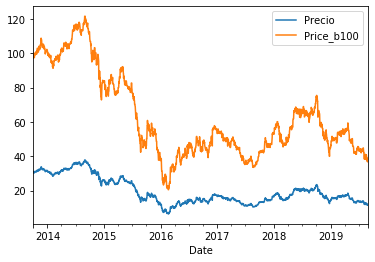

In [16]:
df_precios[df_precios.Ticker=='MRO'].plot()

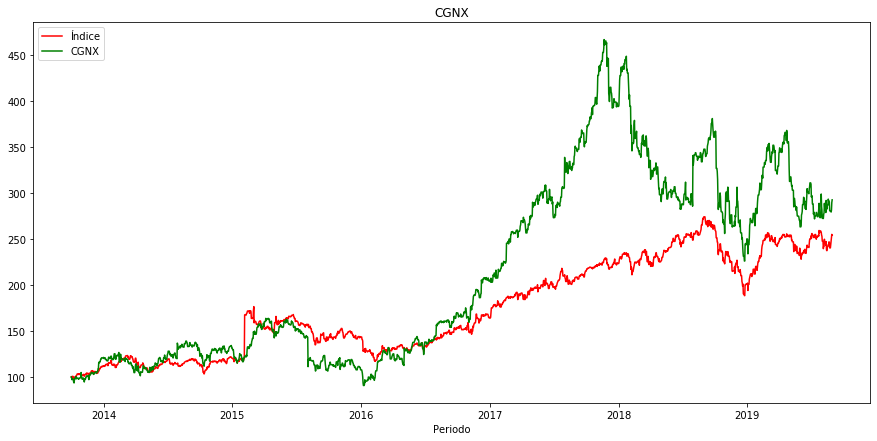

In [17]:
valor_graf = 'CGNX'
indice_graf = indice_tec

xs = df_precios[df_precios['Ticker']==valor_graf].index
ys1 = indice_graf.Price_b100
ys2 = df_precios[df_precios['Ticker']==valor_graf]['Price_b100']
 
fig = plt.figure(figsize=(15,7))
 
plt.plot(xs,ys1,color='r')
plt.plot(xs,ys2,color='g')

hight=800
#plt.xticks(xs,rotation=50)
 
plt.title(valor_graf)
plt.xlabel('Periodo')
 
    
plt.legend(['Índice','%s'%(valor_graf)],loc='upper left')
     
plt.show()

### 4) Incorporamos en la tabla de valores los precios en base 100 de cada valor y del índice correspondientes a la fecha de publicación de cuentas (d) y 180 días después (d+180)

In [18]:
# Filtramos por los Tickers en el set 'valores' y nos quedamos como fecha inicial el 1 de octubre de 2013
df_valores=df_valores[df_valores['Ticker'].isin(list(valores))].reset_index(drop=True)
df_valores= df_valores[(df_valores['Publish Date']>'2013-09-30')].reset_index(drop=True)
df_valores

,Ticker,SimFinId,Currency,Fiscal Year,Fiscal Period,Report Date,Publish Date,Restated Date,Shares (Basic),Shares (Diluted),"Cash, Cash Equivalents & Short Term Investments",Accounts & Notes Receivable,Inventories,Total Current Assets,"Property, Plant & Equipment, Net",Long Term Investments & Receivables,Other Long Term Assets,Total Noncurrent Assets,Total Assets,Payables & Accruals,Short Term Debt,Total Current Liabilities,Long Term Debt,Total Noncurrent Liabilities,Total Liabilities,Share Capital & Additional Paid-In Capital,Treasury Stock,Retained Earnings,Total Equity,Total Liabilities & Equity,Sector,Revenue,Cost of Revenue,Gross Profit,Operating Expenses,"Selling, General & Administrative",Research & Development,Depreciation & Amortization,Operating Income (Loss),Non-Operating Income (Loss),"Interest Expense, Net","Pretax Income (Loss), Adj.",Abnormal Gains (Losses),Pretax Income (Loss),"Income Tax (Expense) Benefit, Net",Income (Loss) from Continuing Operations,Net Extraordinary Gains (Losses),Net Income,Net Income (Common),Periodo
0,AE,191518,USD,2013,Q4,2013-09-30,2014-02-13,2015-03-13,4217596.0,4217596.0,60733000.0,243930000.0,27616000.0,3.517300e+08,91865000.0,NaN,4.487000e+06,9.635200e+07,448082000,271720000.0,NaN,272169000.0,0.0,21228000.0,293397000,1.211500e+07,NaN,1.425700e+08,1.546850e+08,448082000,Energy,9.680960e+08,-18540000.0,9.495560e+08,-9.494530e+08,-9.433250e+08,NaN,-6128000.0,103000.0,95000.0,95000.0,198000.0,NaN,198000.0,-4000.0,194000.0,-85000.0,109000.0,109000.0,2013Q4
1,AE,191518,USD,2014,Q1,2013-12-31,2014-05-12,2014-05-12,4217596.0,4217596.0,87379000.0,227608000.0,39537000.0,3.679420e+08,91908000.0,NaN,4.762000e+06,9.667000e+07,464612000,284416000.0,NaN,284829000.0,NaN,20663000.0,305492000,1.211500e+07,NaN,1.470050e+08,1.591200e+08,464612000,Energy,9.491890e+08,-16852000.0,9.323370e+08,-9.239250e+08,-9.178190e+08,NaN,-6106000.0,8412000.0,42000.0,42000.0,8454000.0,NaN,8454000.0,-3091000.0,5363000.0,NaN,5363000.0,5363000.0,2014Q1
2,AE,191518,USD,2014,Q2,2014-03-31,2014-08-11,2014-08-11,4217596.0,4217596.0,47998000.0,279518000.0,36212000.0,3.881520e+08,89818000.0,NaN,5.174000e+06,9.499200e+07,483144000,301469000.0,NaN,301982000.0,NaN,18995000.0,320977000,1.211500e+07,NaN,1.500520e+08,1.621670e+08,483144000,Energy,1.159931e+09,-16658000.0,1.143273e+09,-1.137197e+09,-1.131088e+09,NaN,-6109000.0,6076000.0,45000.0,45000.0,6121000.0,NaN,6121000.0,-2146000.0,3975000.0,NaN,3975000.0,3975000.0,2014Q2
3,AE,191518,USD,2014,Q3,2014-06-30,2014-11-07,2014-11-07,4217596.0,4217596.0,97435000.0,226300000.0,23324000.0,3.564530e+08,93631000.0,NaN,5.816000e+06,9.944700e+07,455900000,271802000.0,NaN,272290000.0,NaN,18516000.0,290806000,1.211500e+07,NaN,1.529790e+08,1.650940e+08,455900000,Energy,1.173970e+09,-16150000.0,1.157820e+09,-1.154286e+09,-1.148058e+09,NaN,-6228000.0,3534000.0,116000.0,116000.0,3650000.0,2198000.0,5848000.0,-1993000.0,3855000.0,NaN,3855000.0,3855000.0,2014Q3
4,AE,191518,USD,2014,Q4,2014-09-30,2015-02-13,2016-03-11,4217596.0,4217596.0,80184000.0,144434000.0,13481000.0,2.509450e+08,84871000.0,NaN,4.998000e+06,8.986900e+07,340814000,167002000.0,NaN,168603000.0,0.0,14714000.0,183317000,1.211500e+07,NaN,1.453820e+08,1.574970e+08,340814000,Energy,8.497360e+08,-22968000.0,8.267680e+08,-8.378370e+08,-8.316650e+08,NaN,-6172000.0,-11069000.0,96000.0,96000.0,-10973000.0,NaN,-10643000.0,3669000.0,-6974000.0,NaN,-6670000.0,-6670000.0,2014Q4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14161,ZNGA,418866,USD,2018,Q2,2018-06-30,2018-08-03,2018-08-03,858666000.0,858666000.0,392179000.0,99970000.0,NaN,5.411300e+08,264245000.0,NaN,1.180498e+09,1.444743e+09,1985873000,13542000.0,NaN,269683000.0,NaN,116596000.0,386279000,3.462142e+09,NaN,-1.762437e+09,1.599594e+09,1985873000,Technology,2.170450e+08,-74182000.0,1.428630e+08,-1.458490e+08,-7.845800e+07,-67391000.

In [19]:
# Incorporamos el precio de cada valor (campo 'Price_b100) a la tabla df_valores con la función merged
df_valores = df_valores.merge(df_precios, 
                              left_on=('Ticker','Publish Date'),
                              right_on=('Ticker','Date'), 
                              how='left')
#df_valores.drop(['Precio'], axis=1, inplace=True)

df_valores.rename(columns={'Price_b100':'Price_d_100','Precio':'Price_d'}, inplace=True)

In [20]:
df_valores.Ticker.nunique()

620

In [21]:
from datetime import timedelta
#Creamos un nuevo campo a partir de la fecha de publicación y le añadimos 180 días.

df_valores['Publish_Date+180']=df_valores['Publish Date'] + timedelta(days=180)

In [22]:
#Cruzamos ambas tablas

df_valores = df_valores.merge(df_precios, 
                              left_on=('Ticker','Publish_Date+180'),
                              right_on=('Ticker','Date'), 
                              how='left')

#df_valores.drop(['Precio'], axis=1, inplace=True)

df_valores.rename(columns={'Price_b100':'Price_d+180_100','Precio':'Price_d+180'}, inplace=True)

In [23]:
df_valores.head(5)

,Ticker,SimFinId,Currency,Fiscal Year,Fiscal Period,Report Date,Publish Date,Restated Date,Shares (Basic),Shares (Diluted),"Cash, Cash Equivalents & Short Term Investments",Accounts & Notes Receivable,Inventories,Total Current Assets,"Property, Plant & Equipment, Net",Long Term Investments & Receivables,Other Long Term Assets,Total Noncurrent Assets,Total Assets,Payables & Accruals,Short Term Debt,Total Current Liabilities,Long Term Debt,Total Noncurrent Liabilities,Total Liabilities,Share Capital & Additional Paid-In Capital,Treasury Stock,Retained Earnings,Total Equity,Total Liabilities & Equity,Sector,Revenue,Cost of Revenue,Gross Profit,Operating Expenses,"Selling, General & Administrative",Research & Development,Depreciation & Amortization,Operating Income (Loss),Non-Operating Income (Loss),"Interest Expense, Net","Pretax Income (Loss), Adj.",Abnormal Gains (Losses),Pretax Income (Loss),"Income Tax (Expense) Benefit, Net",Income (Loss) from Continuing Operations,Net Extraordinary Gains (Losses),Net Income,Net Income (Common),Periodo,Price_d,Price_d_100,Publish_Date+180,Price_d+180,Price_d+180_100
0,AE,191518,USD,2013,Q4,2013-09-30,2014-02-13,2015-03-13,4217596.0,4217596.0,60733000.0,243930000.0,27616000.0,351730000.0,91865000.0,NaN,4487000.0,96352000.0,448082000,271720000.0,NaN,272169000.0,0.0,21228000.0,293397000,12115000.0,NaN,142570000.0,154685000.0,448082000,Energy,9.680960e+08,-18540000.0,9.495560e+08,-9.494530e+08,-9.433250e+08,NaN,-6128000.0,103000.0,95000.0,95000.0,198000.0,NaN,198000.0,-4000.0,194000.0,-85000.0,109000.0,109000.0,2013Q4,58.19,124.178404,2014-08-12,60.11,128.275715
1,AE,191518,USD,2014,Q1,2013-12-31,2014-05-12,2014-05-12,4217596.0,4217596.0,87379000.0,227608000.0,39537000.0,367942000.0,91908000.0,NaN,4762000.0,96670000.0,464612000,284416000.0,NaN,284829000.0,NaN,20663000.0,305492000,12115000.0,NaN,147005000.0,159120000.0,464612000,Energy,9.491890e+08,-16852000.0,9.323370e+08,-9.239250e+08,-9.178190e+08,NaN,-6106000.0,8412000.0,42000.0,42000.0,8454000.0,NaN,8454000.0,-3091000.0,5363000.0,NaN,5363000.0,5363000.0,2014Q1,57.65,123.026035,2014-11-08,37.39,79.790866
2,AE,191518,USD,2014,Q2,2014-03-31,2014-08-11,2014-08-11,4217596.0,4217596.0,47998000.0,279518000.0,36212000.0,388152000.0,89818000.0,NaN,5174000.0,94992000.0,483144000,301469000.0,NaN,301982000.0,NaN,18995000.0,320977000,12115000.0,NaN,150052000.0,162167000.0,483144000,Energy,1.159931e+09,-16658000.0,1.143273e+09,-1.137197e+09,-1.131088e+09,NaN,-6109000.0,6076000.0,45000.0,45000.0,6121000.0,NaN,6121000.0,-2146000.0,3975000.0,NaN,3975000.0,3975000.0,2014Q2,62.20,132.735809,2015-02-07,54.61,116.538626
3,AE,191518,USD,2014,Q3,2014-06-30,2014-11-07,2014-11-07,4217596.0,4217596.0,97435000.0,226300000.0,23324000.0,356453000.0,93631000.0,NaN,5816000.0,99447000.0,455900000,271802000.0,NaN,272290000.0,NaN,18516000.0,290806000,12115000.0,NaN,152979000.0,165094000.0,455900000,Energy,1.173970e+09,-16150000.0,1.157820e+09,-1.154286e+09,-1.148058e+09,NaN,-6228000.0,3534000.0,116000.0,116000.0,3650000.0,2198000.0,5848000.0,-1993000.0,3855000.0,NaN,3855000.0,3855000.0,2014Q3,37.39,79.790866,2015-05-06,39.14,83.525395
4,AE,191518,USD,2014,Q4,2014-09-30,2015-02-13,2016-03-11,4217596.0,4217596.0,80184000.0,144434000.0,13481000.0,250945000.0,84871000.0,NaN,4998000.0,89869000.0,340814000,167002000.0,NaN,168603000.0,0.0,14714000.0,183317000,12115000.0,NaN,145382000.0,157497000.0,340814000,Energy,8.497360e+08,-22968000.0,8.267680e+08,-8.378370e+08,-8.316650e+08,NaN,-6172000.0,-11069000.0,96000.0,96000.0,-10973000.0,NaN,-10643000.0,3669000.0,-6974000.0,NaN,-6670000.0,-6670000.0,2014Q4,56.70,120.998720,2015-08-12,40.81,87.089202


In [24]:
#Cruzamos la tabla de valores con los precios de df_índice

df_valores = df_valores.merge(df_indice, 
                              left_on=('Publish Date','Sector'),
                              right_on=('Date','Sector'), 
                              how='left')

df_valores.rename(columns={'Price_b100':'Indice_d_100'}, inplace=True)

df_valores = df_valores.merge(df_indice, 
                              left_on=('Publish_Date+180','Sector'),
                              right_on=('Date','Sector'), 
                              how='left')

df_valores.rename(columns={'Price_b100':'Indice_d+180_100'}, inplace=True)

In [25]:
#Eliminamos los últimos periodos para los que no hay precio en d+180

df_valores=df_valores[df_valores['Price_d+180_100'].notnull()]

### 5) Cálculo de las diferencias entre la evolución de los precios y la evolución del índice. Etiquetado a partir de dichas diferencias

In [26]:
df_valores['Var_cotiz']=(df_valores['Price_d+180_100']-df_valores['Price_d_100'])/df_valores['Price_d_100']
df_valores['Var_index']=(df_valores['Indice_d+180_100']-df_valores['Indice_d_100'])/df_valores['Indice_d_100']

In [27]:
def etiquetado(row):
    limite = 0.00
    dif = row['Var_cotiz'] - row['Var_index']
    if dif > limite:
        return 'Mejor'
    elif dif < limite:
        return 'Peor'
    else:
        return 'Error'

In [28]:
df_valores['Etiqueta']=df_valores.apply(etiquetado,axis=1)

In [29]:
df_valores.pivot_table(index='Etiqueta', columns='Sector',aggfunc={'Ticker': 'count'})

Ticker                                  
Sector   Energy Healthcare Industrials Technology
Etiqueta                                         
Error         4          7          14         13
Mejor       617       1471        1857       1998
Peor        658       1821        2040       2244

In [30]:
df_valores=df_valores[df_valores.Etiqueta != 'Error']

Guardamos la tabla obtenida

In [31]:
df_valores.to_csv('../tablas/registros_etiq.csv', index=False)

Por último, vamos a generar tablas específicas para cada índice, recogiendo las rentabilidades por periodo, para más adelante poderlo comparar con el rendimiento de nuestra cartera.

In [41]:
df_var_indice_tec=pd.DataFrame(columns=['Sector','Periodo','Indice_d_100','Indice_d+180_100','Rent_indice'])
df_var_indice_ind=df_var_indice_tec
df_var_indice_health=df_var_indice_tec
df_var_indice_energy=df_var_indice_tec

In [42]:
df_valores.Sector.unique()

array(['Energy', 'Healthcare', 'Industrials', 'Technology'], dtype=object)

In [43]:
for periodo in df_valores.Periodo.unique():
    aux_table=df_valores[(df_valores['Periodo']==periodo) & (df_valores['Sector']=='Technology')]
    df_var_indice_tec=df_var_indice_tec.append({'Sector':'Technology',
                                                'Periodo':periodo,
                                                'Indice_d_100':aux_table.Indice_d_100.mean(),
                                                'Indice_d+180_100':aux_table['Indice_d+180_100'].mean(),
                                                'Rent_indice':(aux_table['Indice_d+180_100'].mean()*100/(aux_table.Indice_d_100.mean())-100)},
                                                 ignore_index=True)
    
for periodo in df_valores.Periodo.unique():
    aux_table=df_valores[(df_valores['Periodo']==periodo) & (df_valores['Sector']=='Energy')]
    df_var_indice_energy=df_var_indice_energy.append({'Sector':'Energy',
                                                'Periodo':periodo,
                                                'Indice_d_100':aux_table.Indice_d_100.mean(),
                                                'Indice_d+180_100':aux_table['Indice_d+180_100'].mean(),
                                                'Rent_indice':(aux_table['Indice_d+180_100'].mean()*100/(aux_table.Indice_d_100.mean())-100)},
                                                 ignore_index=True)
    
for periodo in df_valores.Periodo.unique():
    aux_table=df_valores[(df_valores['Periodo']==periodo) & (df_valores['Sector']=='Healthcare')]
    df_var_indice_health=df_var_indice_health.append({'Sector':'Healthcare',
                                                'Periodo':periodo,
                                                'Indice_d_100':aux_table.Indice_d_100.mean(),
                                                'Indice_d+180_100':aux_table['Indice_d+180_100'].mean(),
                                                'Rent_indice':(aux_table['Indice_d+180_100'].mean()*100/(aux_table.Indice_d_100.mean())-100)},
                                                 ignore_index=True)
    
for periodo in df_valores.Periodo.unique():
    aux_table=df_valores[(df_valores['Periodo']==periodo) & (df_valores['Sector']=='Industrials')]
    df_var_indice_ind=df_var_indice_ind.append({'Sector':'Industrials',
                                                'Periodo':periodo,
                                                'Indice_d_100':aux_table.Indice_d_100.mean(),
                                                'Indice_d+180_100':aux_table['Indice_d+180_100'].mean(),
                                                'Rent_indice':(aux_table['Indice_d+180_100'].mean()*100/(aux_table.Indice_d_100.mean())-100)},
                                                 ignore_index=True)

In [44]:
df_var_indice_energy.to_csv('../tablas/var_indice_energy.csv', index=False)
df_var_indice_tec.to_csv('../tablas/var_indice_tec.csv', index=False)
df_var_indice_health.to_csv('../tablas/var_indice_health.csv', index=False)
df_var_indice_ind.to_csv('../tablas/var_indice_ind.csv', index=False)